# Simple feed forward NN to predict IC50 based on patient demographic and molecular drug information (EXCLUDES CELL LINE FEATURE FROM TRAINING)

In [2]:
from CHEM277B_functions import *

In [4]:
valid_IC50s = pd.read_csv("data/valid_IC50s_within_range.csv")
merged_df = pd.read_csv("data/final_merged_imputed_race_CSV.csv")
lucas_df = pd.read_csv("data/Raw_Mapping_Imputed_Race.csv")
cell_lines_df = pd.read_csv("data/HarvardCellLines.csv")

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_13056/1684730604.py:2: DtypeWarning: Columns (3,4,5,6,7,9,12,15,16,17,18,22,24,26,28,29,30,67) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("final_merged_imputed_race_CSV.csv")


In [6]:
valid_IC50s.drop(columns = ['Unnamed: 0', 'N Points'], inplace = True)

In [8]:
cell_lines_df.columns

Index(['HMS LINCS Batch ID', 'HMS LINCS ID', 'Name', 'Alternative Names',
       'LINCS ID', 'Alternative ID', 'Reference Source', 'Organism', 'Organ',
       'Tissue', 'Cell Type', 'Details of Cell Type', 'Donor Sex', 'Donor Age',
       'Donor Ethnicity', 'Donor Health Status', 'Disease', 'Unnamed: 17',
       'Details of Disease', 'Production Details', 'Genetic Modification(s)',
       'Known Mutations', 'Citation Information for Mutations',
       'Verification Reference Profile', 'Growth Properties',
       'Recommended Culture Conditions', 'Relevant Citations', 'Usage Note',
       'Comments', 'Provider', 'Provider Catalog ID', 'Provider Batch ID',
       'Source Information', 'Date Received', 'HMS QC Outcome',
       'Transient Modification(s)', 'Date Publicly Available',
       'Most Recent Update', 'T Stage'],
      dtype='object')

In [10]:
columns = ["HMS LINCS Batch ID", "Name", "T Stage"]
cell_lines_df = cell_lines_df[columns]

In [12]:
merged_df['T_stage_by_size'] = merged_df.apply(lambda row: row['T Stage'] if pd.notnull(row['T Stage']) else T_stage_by_size(row['Tumor Size']), axis=1)

# USE LUCAS' DATASET STARTING HERE

In [15]:
columns = ['Age', 'Race', 'T_stage_by_size']
patients_df = merged_df[columns]

In [19]:
patients_df["cell_lines"] = lucas_df["Matched Cell Line ID"]

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_13056/3231217547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_df["cell_lines"] = lucas_df["Matched Cell Line ID"]


In [21]:
cell_lines_df_dict = cell_lines_df.set_index("HMS LINCS Batch ID").to_dict()["Name"]

In [27]:
patients_df["Cell Name"] = patients_df["cell_lines"].apply(mapping, dictionary = cell_lines_df_dict)

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_13056/1850949227.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_df["Cell Name"] = patients_df["cell_lines"].apply(mapping, dictionary = cell_lines_df_dict)


In [31]:
patients_df.dropna(inplace=True)
patients_df.isna().sum()

/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_13056/2483854490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients_df.dropna(inplace=True)


Age                0
Race               0
T_stage_by_size    0
cell_lines         0
Cell Name          0
dtype: int64

# Add Small Molecule descriptors for each row. 

In [33]:
drugs_df = pd.read_csv("Descriptors_Small_Molecules.csv")
drugs_df = drugs_df[['Name', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]
drugs_df.rename(columns={'Name': 'Small Molecule Name'}, inplace=True)
drugs_df.head()

,Small Molecule Name,Molecular Mass,LogP,NumHDonors,NumHAcceptors,TPSA
0,AZD7762,362.12,2.52660,4,4,96.25
1,Neratinib,556.20,5.93248,2,8,112.40
2,Dasatinib,487.16,3.31354,3,9,106.51
3,Saracatinib,541.21,3.93950,1,10,90.44
4,Pictilisib,513.16,2.14840,1,9,107.55


In [35]:
valid_IC50s = pd.merge(valid_IC50s, drugs_df, on='Small Molecule Name', how='left')

In [37]:
patient_drug_df = pd.merge(patients_df, valid_IC50s, on='Cell Name', how='left')

In [39]:
patient_drug_df.drop(columns = "cell_lines", inplace=True)

In [41]:
patient_drug_df.to_csv("patient_drug_information_aka_final_final_final.csv")

In [43]:
race_dict = {0:'N/A', 1:"white", 2:"black", 3:"asian", 4:"native", 5:"hispanic", 6:"multi", 7:"hawa", 8:"amer indian"}

In [45]:
patient_drug_df["Race"] = patient_drug_df["Race"].apply(mapping, dictionary = race_dict)

### Cell lines are proxy for patients, so drop the cell lines column. 

In [47]:
patient_drug_df.drop(columns="Cell Name", inplace=True)

### Need to one-hot-encode categorical featurs

In [50]:
categorical_cols = ['Race', 'T_stage_by_size', 'Small Molecule Name']
patient_drug_df[categorical_cols] = patient_drug_df[categorical_cols].astype('category')

In [54]:
patient_drug_df_encoded = pd.get_dummies(patient_drug_df, columns=categorical_cols, drop_first=True)

In [56]:
bool_cols = patient_drug_df_encoded.select_dtypes(include='bool').columns
patient_drug_df_encoded[bool_cols] = patient_drug_df_encoded[bool_cols].astype(int)

### PRE-PROCESSING DONE. ONTO MODEL TRAINING.

In [58]:
# Separate features (X) and target (y)
X = patient_drug_df_encoded.drop(columns=['EC50 (uM)'])  # Drop EC50 and non-features
y = patient_drug_df_encoded['EC50 (uM)']  # EC50 is the target

# Standardize numerical features
scaler = StandardScaler()
X[['Age', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']] = scaler.fit_transform(X[['Age', 'Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]) 

In [60]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Data
# Select drug descriptor columns
drug_feature_cols = ['Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']
drug_features = X_train[drug_feature_cols].to_numpy()  # (n_samples, 5)

# Drop drug features to get patient features
patient_features = X_train.drop(columns=drug_feature_cols).to_numpy()

# Convert to tensors
drug_tensor = torch.tensor(drug_features).float()
patient_tensor = torch.tensor(patient_features).float()
ic50_tensor = torch.tensor(y_train.to_numpy()).float()

model = DrugResponsePredictor(drug_input_dim=5, patient_input_dim=patient_tensor.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


# Training loop
model.train()
start_time = time.time()

my_epochs = []
my_losses = []

for epoch in range(300):  
    optimizer.zero_grad()
    preds = model(drug_tensor, patient_tensor)
    loss = loss_fn(preds, ic50_tensor)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    elapsed = end_time - start_time
    print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    print(f"Time elapsed: {elapsed:.2f} seconds")
    my_epochs.append(epoch)
    my_losses.append(loss.item())


Epoch 0 | Loss: 2.9137
Time elapsed: 0.06 seconds
Epoch 1 | Loss: 2.8801
Time elapsed: 0.09 seconds
Epoch 2 | Loss: 2.8484
Time elapsed: 0.12 seconds
Epoch 3 | Loss: 2.8184
Time elapsed: 0.15 seconds
Epoch 4 | Loss: 2.7895
Time elapsed: 0.18 seconds
Epoch 5 | Loss: 2.7615
Time elapsed: 0.21 seconds
Epoch 6 | Loss: 2.7342
Time elapsed: 0.24 seconds
Epoch 7 | Loss: 2.7071
Time elapsed: 0.27 seconds
Epoch 8 | Loss: 2.6792
Time elapsed: 0.30 seconds
Epoch 9 | Loss: 2.6506
Time elapsed: 0.33 seconds
Epoch 10 | Loss: 2.6215
Time elapsed: 0.35 seconds
Epoch 11 | Loss: 2.5919
Time elapsed: 0.38 seconds
Epoch 12 | Loss: 2.5618
Time elapsed: 0.41 seconds
Epoch 13 | Loss: 2.5315
Time elapsed: 0.44 seconds
Epoch 14 | Loss: 2.5010
Time elapsed: 0.47 seconds
Epoch 15 | Loss: 2.4702
Time elapsed: 0.50 seconds
Epoch 16 | Loss: 2.4388
Time elapsed: 0.53 seconds
Epoch 17 | Loss: 2.4071
Time elapsed: 0.56 seconds
Epoch 18 | Loss: 2.3752
Time elapsed: 0.59 seconds
Epoch 19 | Loss: 2.3433
Time elapsed: 0.6

In [77]:
epochs_vs_loss_without_cells(my_epochs, my_losses)

NameError: name 'epochs_vs_loss_without_cells' is not defined

In [57]:
drug_features_test = X_test[['Molecular Mass', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA']]
patient_features_test = X_test.drop(columns=drug_features_test.columns)

metrics = evaluate_model(model, drug_features_test, patient_features_test, y_test)

print(f"MSE: {metrics[0]:.4f}")
print(f"MAE: {metrics[1]:.4f}")
print(f"R²: {metrics[2]:.4f}")


MSE: 0.3875
MAE: 0.2711
R²: 0.8248


/var/folders/s8/ghqk1l4n7n9_w17t7hx21g2m0000gn/T/ipykernel_7821/778809264.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--', label='Ideal', color = "Black")


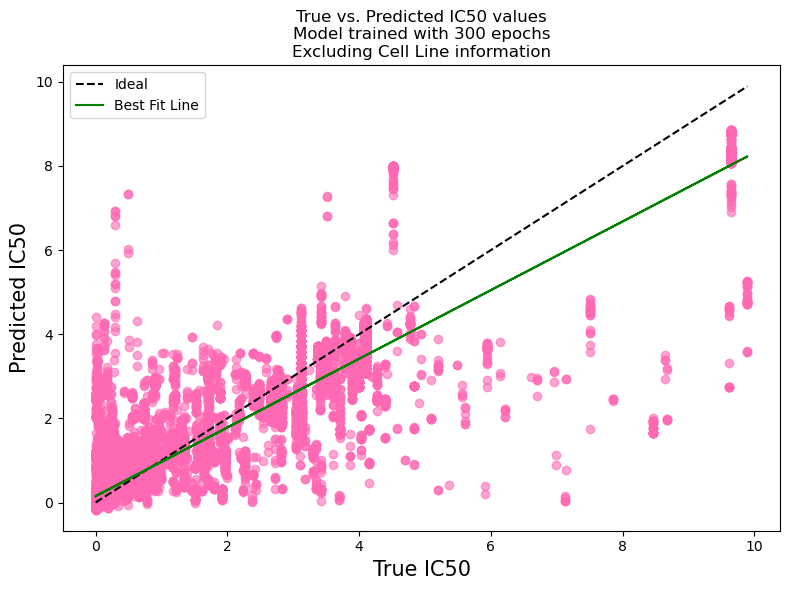

In [132]:
with torch.no_grad():
    preds = model(torch.tensor(drug_features_test.values).float(),
                  torch.tensor(patient_features_test.values).float()).cpu().numpy()
plot_pred_vs_true_without_cells(y_test.to_numpy(), preds)

In [61]:
k_fold_cv = compute_CV_error(X_train,y_train)

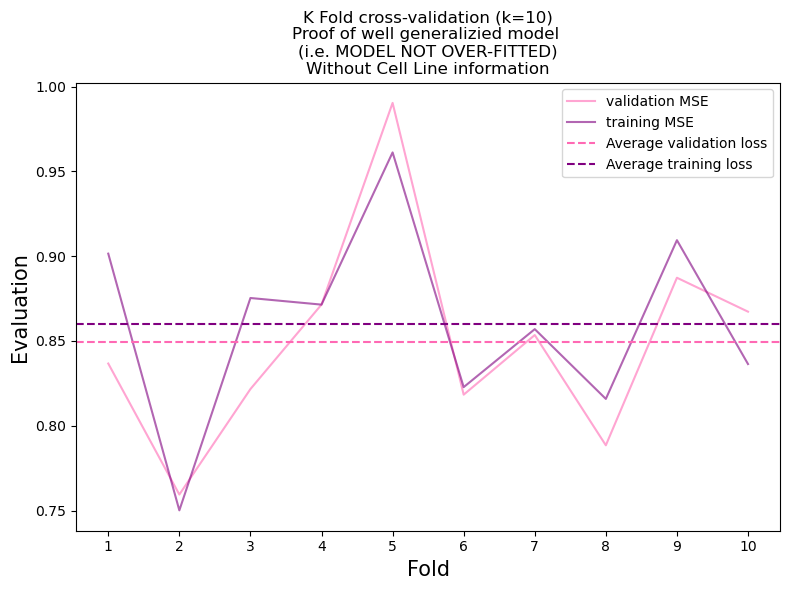

In [63]:
Kfold_CV_plot_without_cells(k_fold_cv)